In [1]:
import cv2

In [2]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [3]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

from functools import partial
from sklearn.decomposition import PCA
import scipy
from matplotlib import pyplot as plt
from sklearn.mixture import BayesianGaussianMixture as bnpc

In [4]:
import shutil
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [5]:
%%time 
import ants

CPU times: user 1.18 s, sys: 559 ms, total: 1.74 s
Wall time: 5.91 s


### LOAD DATA

In [6]:
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

In [7]:
ABIDE_data = np.load(dataFnOut)['data']
#ABIDE_data = np.load('/mmfs1/data/aglinska/3d_grassy_mnist/fake_abide.npy')
df = pd.read_csv(dfFnOut)

In [8]:
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

In [9]:
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

### LOAD NETWORK WEIGHTS

In [10]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading


In [11]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'
#fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
fn = 'Feb04_0524_D16B1G100_DTrue'

#fn = os.path.join(fdir,fn)
fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'
#fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb26_1330_forPaperFakeAbide'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

### CHECK NETWORKS

In [12]:
sfari_td_batch = SFARI_data[sfari_subs_td,:,:,:][0:15,:,:,:]
sfari_dupl_batch = SFARI_data[sfari_subs_dupl,:,:,:][0:15,:,:,:]
sfari_del_batch = SFARI_data[sfari_subs_del,:,:,:][0:15,:,:,:]

asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)

In [13]:
def cvae_predict(im_in,idx=1):
    # 0 for ASD, 1 for TD
    #im_in = [DX_batch,TD_batch][idx]
    _zeros = np.zeros(s_encoder(im_in)[2].shape)

    v = 2
    cvae_sal_vec = np.hstack((_zeros,s_encoder(im_in)[v]))
    cvae_bg_vec = np.hstack((z_encoder(im_in)[v],_zeros))

    if idx==1:
        cvae_full_vec = np.hstack((z_encoder(im_in)[v],s_encoder(im_in)[v]))
    elif idx==0:
        cvae_full_vec = cvae_bg_vec
        
    out = cvae_decoder.predict(cvae_full_vec)
    
    return out[:,:,:,:,0]

Text(0, 0.5, 'MSE')

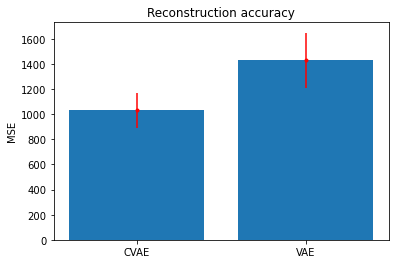

In [14]:
asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
#DX_batch = np.take(ABIDE_data, indices=td_idx, axis=0)

matIn = DX_batch
n = matIn.shape[0]

vae_out = decoder.predict(encoder(matIn)[2])[:,:,:,:,0]
cvae_out = cvae_predict(matIn,idx=1)

vae_resid = (matIn-vae_out)**2
cvae_resid = (matIn-cvae_out)**2

vae_acc = np.array([vae_resid[i,:,:,:].sum() for i in range(n)])
cvae_acc = np.array([cvae_resid[i,:,:,:].sum() for i in range(n)])

xs = [0,1];
m = [cvae_acc.mean(),vae_acc.mean()];
se = [cvae_acc.std(),vae_acc.std()];
plt.bar(xs,m);
plt.errorbar(xs,m,se,fmt='r.');
plt.xticks(xs,labels=['CVAE','VAE']);
plt.title('Reconstruction accuracy')
plt.ylabel('MSE')

### ^VAE is a bit worse at reconstruction overall. This needs to be fixed. For these analyses here it doesnt matter much because the reconstructions are still fairly ok. And also - we're mostly interested in the difference between BG and SL space

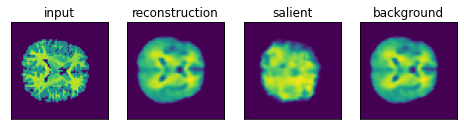

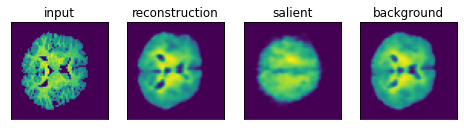

In [15]:
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0) # PLOT ASD SUBJECT
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1) # PLOT TD SUBJECT

### CVAE Reconstructions look good

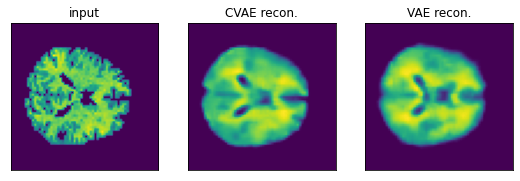

In [16]:
s = 1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1);plt.imshow(matIn[s,:,:,40]);plt.title('input');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,2);plt.imshow(cvae_out[s,:,:,40]);plt.title('CVAE recon.');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,3);plt.imshow(vae_out[s,:,:,40]);plt.title('VAE recon.');plt.xticks([]);plt.yticks([]);

### For CVAE and VAE reconstruct the brain images well

### Distributions of ASD subjects in the three spaces. Evidence of clustering in BG, SL and VAE seem random (RSA results will show how they are organized)

In [18]:
svec = s_encoder.predict(ABIDE_data)

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



470


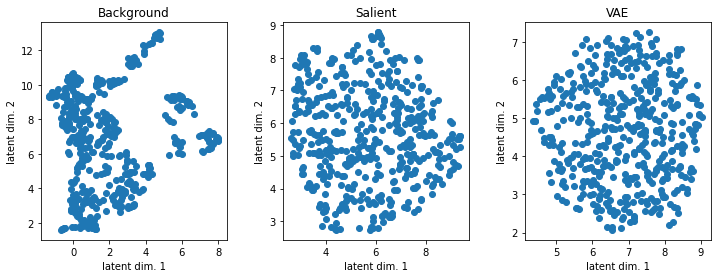

In [121]:
w = 2
vae_space = dim_reduce(encoder.predict(ABIDE_data)[w])
bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=w, method='UMAP')

fig = cscatter([bg_space,sl_space,vae_space],v=patients,return_axes=True)
#fig.savefig('/mmfs1/data/aglinska/figures/CVAE_clusters_nocolour.png')

In [21]:
cid = bnpc(n_components=50,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=100,
    n_init=1,
    init_params='kmeans',
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=None,
    mean_precision_prior=None,
    mean_prior=None,
    degrees_of_freedom_prior=None,
    covariance_prior=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10).fit_predict(bg_space[patients])

len(np.unique(cid))

7

In [22]:
def cscatter(spaces,v=None,c=None,clim=None,clbl=None,legend=None,return_axes=False):
    space_lbls = ['Background','Salient','VAE']

    if type(v)==type(None):
        v = np.repeat(True,len(spaces[0]))
        
    fig = plt.figure(figsize=(12,4))
    for i in range(len(spaces)):
        plt.subplot(1,3,i+1)
        
        if type(c)!=type(None) and len(np.unique(c)) > 10: # continus colourbar
            #print('continuues colourbar')
            
            plt.scatter(spaces[i][v,0],spaces[i][v,1],c=c)
            if type(clim)==type(None): #if clim not passed, 
                clim = (min(c),max(c)) # calc min max
            plt.clim(clim[0],clim[1]) # do clim regardless
                
            cbar = plt.colorbar()
            cbar.ax.set_ylabel(clbl,rotation=270,labelpad=20,fontsize=16,fontweight='bold')    
                
        elif type(c)!=type(None) and len(np.unique(c)) < 10: # categorical colourbar
            #print('categorical colourbar')
            for j in np.unique(c):
                plt.scatter(spaces[i][c[v]==j,0],spaces[i][c[v]==j,1],alpha=.5)
                    
            if type(legend)==type(None):
                legend = [str(i) for i in np.unique(c)]    
            plt.legend(legend)

        else:
           #print('else')
            plt.scatter(spaces[i][v,0],spaces[i][v,1])
            
        
        #plt.scatter(spaces[i][v,0],spaces[i][v,1],c=c)
        plt.xlabel('latent dim. 1');plt.ylabel('latent dim. 2')
        plt.title(space_lbls[i])

    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=.3,hspace=None,) 
    print(sum(v))
    
    if return_axes:
        return fig
    

470


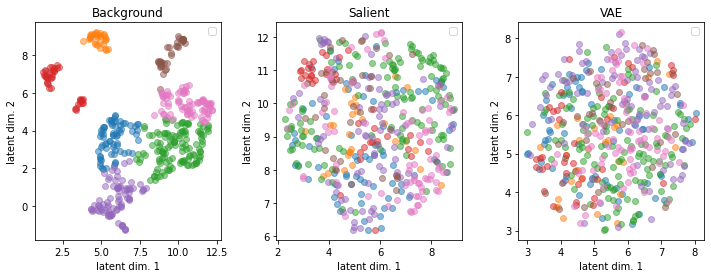

In [23]:
cscatter([bg_space[patients,:],sl_space[patients,:],vae_space[patients,:]],c=cid,legend=[],return_axes=False)
plt.savefig('/mmfs1/data/aglinska/fig.png')

In [24]:
%%time
v = patients
rdm_bg = 1-make_RDM(bg_space[v,:],data_scale='ratio')
rdm_sl = 1-make_RDM(sl_space[v,:],data_scale='ratio')
rdm_vae = 1-make_RDM(encoder.predict(ABIDE_data)[2][v,:],data_scale='ratio')

CPU times: user 1.04 s, sys: 569 ms, total: 1.61 s
Wall time: 782 ms


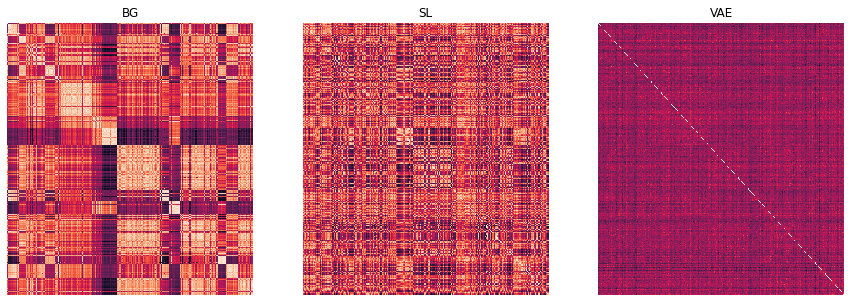

In [25]:
f, ax = plt.subplots(1,3,figsize=(15,5))
sns.heatmap(rdm_bg,cbar=[],ax=ax[0],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_sl,cbar=[],ax=ax[1],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_vae,cbar=[],ax=ax[2],xticklabels=[],yticklabels=[]);

[ax[i].set_title(['BG','SL','VAE'][i]) for i in range(3)];

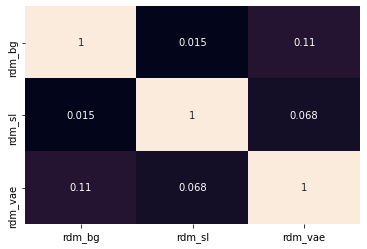

In [26]:
space_cmat = np.corrcoef(np.array([get_triu(x) for x in [rdm_bg,rdm_sl,rdm_vae]]));
lbls= ['rdm_bg','rdm_sl','rdm_vae'];
sns.heatmap(space_cmat,annot=True,cbar=[],xticklabels=lbls,yticklabels=lbls);

In [27]:
from sklearn.mixture import BayesianGaussianMixture

In [28]:
n_clust = 3
bnp = BayesianGaussianMixture(n_components=n_clust,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=1000,
    n_init=10,
    init_params='kmeans',
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=None,
    mean_precision_prior=None,
    mean_prior=None,
    degrees_of_freedom_prior=None,
    covariance_prior=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10)

In [29]:
cid_s = bnp.fit_predict(s_encoder.predict(ABIDE_data[patients,:,:,:])[0])
zeros = np.zeros(16)

In [30]:
out = cvae_decoder.predict(np.array([np.hstack((zeros,bnp.means_[i,:])) for i in range(n_clust)]))

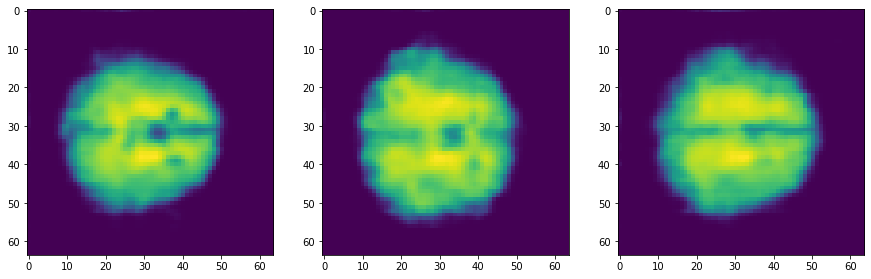

In [31]:
f, ax = plt.subplots(1,n_clust,figsize=(5*n_clust,5))
for i in range(n_clust):
    ax[i].imshow(out[i,:,:,40,:])

In [32]:
from scipy.stats import multivariate_normal
i = 1

In [33]:
mu = bnp.means_[i]
cov = np.linalg.inv(bnp.precisions_[i])

In [34]:
n_sample = 10
sampled_vec = multivariate_normal(mean=mu, cov=cov, allow_singular=False, seed=None).rvs(size=n_sample)
zeros = np.zeros(sampled_vec.shape)
imOut = cvae_decoder.predict(np.hstack((zeros,sampled_vec)))
#plt.imshow(im)

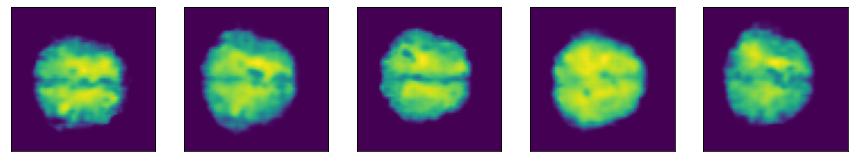

In [35]:
f,ax = plt.subplots(1,5,figsize=(15,5))
[ax[i].imshow(imOut[i,:,:,40,0]) for i in range(5)];
[a.set_xticks([]) for a in ax];
[a.set_yticks([]) for a in ax];

In [36]:
def plot_three(im):
    f,ax = plt.subplots(1,3,figsize=(15,5));
    ii = np.argmax([im[i,:,:].sum() for i in range(im.shape[2])]);
    jj = np.argmax([im[:,i,:].sum() for i in range(im.shape[2])]);
    kk = np.argmax([im[:,:,i].sum() for i in range(im.shape[2])]);

    ax[0].imshow(im[ii,:,:]);
    ax[1].imshow(im[:,jj,:]);
    ax[2].imshow(im[:,:,kk]);

    [a.set_xticks([]) for a in ax];
    [a.set_yticks([]) for a in ax];

In [122]:
data = ABIDE_data[patients,:,:,:]
w = 2
space_sl = s_encoder.predict(data)[w]
space_bg = z_encoder.predict(data)[w]

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(470, 2)


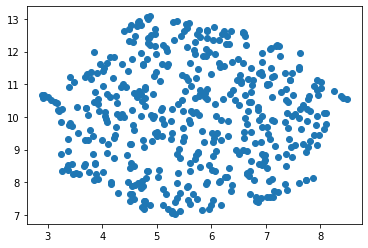

In [123]:
reducer = umap.UMAP(n_components=2)
s_embedding = reducer.fit_transform(space_sl)
plt.scatter(s_embedding[:,0],s_embedding[:,1])
print(s_embedding.shape)

In [39]:
def inverse_tx_umap(targ,s_embedding):
    #targ = [4,11]
    targ = np.array(targ)
    idx = np.argsort(((s_embedding-targ)**2).sum(axis=1))
    #print(idx[0])
    #print(s_embedding[idx[0],:])
    return idx

In [131]:
fn = '/mmfs1/data/aglinska/BC-MRI-AE/Data/anat_temp.nii'
im = ants.image_read(fn)
im = ants.resample_image(image=im,resample_params=(64,64,64),use_voxels=True,interp_type=1)
#im.plot(nslices=5)

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [41]:
def get_brain_pair(b_vec,s_vec):
#     s_vec = space_sl[idx,:]
#     b_vec = space_bg[idx,:]

    vec_asd = np.hstack((b_vec,s_vec))
    vec_td = np.hstack((b_vec,np.zeros(16)))

    im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
    im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]
    
    thresh = 0.1
    im_asd[im_asd<thresh]=0
    im_td[im_td<thresh]=0
    
    nii_asd = im.new_image_like(im_asd)
    nii_td = im.new_image_like(im_td)
    
    return nii_td,nii_asd

In [42]:
def getTxVec(s):
    
    nii_td,nii_asd = get_brain_pair(space_bg[s,:],space_sl[s,:])
    #tx = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='SyN')
    
    imtx = ants.image_read(os.path.join('/mmfs1/data/aglinska/Tx/',f's{s:04}_BGtoASD.nii.gz'))
    arr = imtx.numpy()
    txVec = np.array([arr[:,:,:,i].flatten().mean() for i in range(3)])
    
    return txVec

In [44]:
template = ants.image_read('/mmfs1/data/aglinska/BC-ASD-FC/Atlas/Atlas_brain_2mm.nii')
template = ants.resample_image(template,(64,64,64),use_voxels=True)

In [45]:
def smooth_brainDif(nii_diff):
    nii_diff = nii_diff.smooth_image(6,sigma_in_physical_coordinates=False,FWHM=True,max_kernel_width=128)
    #nii_diff[np.abs(nii_diff.numpy())<.01]=0
    #nii_diff = nii_diff.new_image_like(nii_diff.numpy()-np.median(nii_diff.numpy().flatten()))
    #nii_diff = ants.iMath_normalize(nii_diff)
    #nii_diff.plot(nslices=5,crop=True)
    #nii_td.smooth_image(6,sigma_in_physical_coordinates=False,FWHM=True,max_kernel_width=128).plot(overlay=nii_diff,overlay_alpha=.3,nslices=5,crop=True,axis=0)
    #nii_td.smooth_image(6,sigma_in_physical_coordinates=False,FWHM=True,max_kernel_width=128).plot(overlay=nii_diff,overlay_alpha=.3,nslices=5,crop=True,axis=1)
    #nii_td.smooth_image(6,sigma_in_physical_coordinates=False,FWHM=True,max_kernel_width=128).plot(overlay=nii_diff,overlay_alpha=.3,nslices=5,crop=True,axis=2)
    return nii_diff

In [46]:
def get_brain_pair(b_vec,s_vec):

    vec_asd = np.hstack((b_vec,s_vec))
    vec_td = np.hstack((b_vec,np.zeros(16)))

    im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
    im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]
    
    thresh = 0.0
    im_asd[im_asd<thresh]=0
    im_td[im_td<thresh]=0
    
    nii_asd = im.new_image_like(im_asd)
    nii_td = im.new_image_like(im_td)
    
    return nii_td,nii_asd

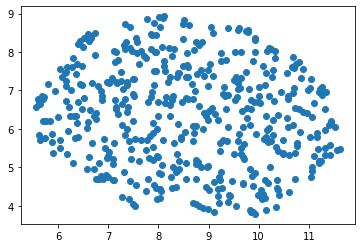

In [48]:
plt.scatter(s_embedding[:,0],s_embedding[:,1]);

In [49]:
def get_umap_corners(s_embedding):
    ax_min = s_embedding.min(axis=0)
    ax_max = s_embedding.max(axis=0)
    ll = inverse_tx_umap((ax_min[0],ax_min[1]),s_embedding)
    lr = inverse_tx_umap((ax_max[0],ax_min[1]),s_embedding)
    tl = inverse_tx_umap((ax_min[0],ax_max[1]),s_embedding)
    tr = inverse_tx_umap((ax_max[0],ax_max[1]),s_embedding)
    cntr = inverse_tx_umap(s_embedding.mean(axis=0),s_embedding)
    
    map_ = dict()
    map_['ll'] = ll
    map_['lr'] = lr
    map_['tr'] = tr
    map_['tl'] = tl
    map_['center'] = cntr

    return map_

In [52]:
def plot_2dvecfield(U,V,ax=None):
    X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
    
    #U  = flow[0:-1:2,0:-1:2,1]
    #V  = flow[0:-1:2,0:-1:2,0]

    if not ax:
        fig, ax = plt.subplots()
        #ax3.set_title("pivot='tip'; scales with x view")

    M = np.hypot(U, V)
    Q = ax.quiver(X, Y, U, V, M, units='x', pivot='tip', width=0.022,
                   scale=1/0.15)

    qk = ax.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                       coordinates='figure')
    ax.scatter(X, Y, color='0.5', s=1)
    plt.xticks([]);plt.yticks([])

    #plt.show()

In [55]:
def func_get_td_to_asd_warp(corner,i):
    map_ = get_umap_corners(s_embedding)
    idx = map_[corner][i]
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])
    anat = im.new_image_like(abide_asd[idx,:,:,:])
    norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
    warp = ants.registration(fixed=norm_asd,moving=norm_td,type_of_transform='SyNOnly')
    warp_nii = ants.image_read(warp['fwdtransforms'][0])
    return warp_nii

In [132]:
def get_diff_norm(corner,i,smooth=False):
    map_ = get_umap_corners(s_embedding)
    idx = map_[corner][i]
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])
    anat = im.new_image_like(abide_asd[idx,:,:,:])
    norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
    diff = norm_asd-norm_td
    
    if smooth==True:
        diff = diff.smooth_image(sigma=6,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)
    
    return diff

In [138]:
def norm_brains(anat,template,nii_td,nii_asd,tmp='/scratch/aglinska/',return_tx=False):

    reg_iterations = (40, 20, 0)
    aff_iterations = (2100, 1200, 1200, 10)
    #norm = ants.registration(fixed=template,moving=anat,type_of_transform='SyN',reg_iterations=reg_iterations,aff_iterations=aff_iterations,outprefix=tmp)
    norm = ants.registration(fixed=template,moving=anat,type_of_transform='SyN',reg_iterations=reg_iterations,aff_iterations=aff_iterations)
    #norm_td = norm['warpedmovout']
    
    norm_asd = ants.apply_transforms(fixed=template,moving=nii_asd,transformlist=norm['fwdtransforms'])
    norm_td = ants.apply_transforms(fixed=template,moving=nii_td,transformlist=norm['fwdtransforms'])
    
    norm_asd.set_origin = template.origin
    norm_td.set_origin = template.origin
    
    if return_tx:
        return norm_td,norm_asd,norm
    else:
        return norm_td,norm_asd

In [143]:
#norm['fwdtransforms']

265

In [126]:
def get_diff(corner,i):
    map_ = get_umap_corners(s_embedding)
    idx = map_[corner][i]
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])
    anat = im.new_image_like(abide_asd[idx,:,:,:])
    norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
    diff = (norm_asd-norm_td)
    #diff = (norm_td-norm_asd)
    return diff

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [127]:
%%time
vec1 = [get_diff('ll',i).numpy() for i in tqdm(range(10))]
vec2 = [get_diff('lr',i).numpy() for i in tqdm(range(10))]
vec3 = [get_diff('tr',i).numpy() for i in tqdm(range(10))]
vec4 = [get_diff('tl',i).numpy() for i in tqdm(range(10))]

100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

CPU times: user 5min 45s, sys: 31.3 s, total: 6min 16s
Wall time: 58.1 s


In [211]:
geom1

,Label,VolumeInMillimeters,SurfaceAreaInMillimetersSquared,Eccentricity,Elongation,Orientation,Centroid_x,Centroid_y,Centroid_z,AxesLength_x,...,BoundingBoxLower_x,BoundingBoxUpper_x,BoundingBoxLower_y,BoundingBoxUpper_y,BoundingBoxLower_z,BoundingBoxUpper_z,IntegratedIntensity,WeightedCentroid_x,WeightedCentroid_y,WeightedCentroid_z
0,1,487304.956268,162618.843763,0.629722,1.287299,1.603611,31.307105,29.776233,24.778129,48.230145,...,7,55,7,59,2,54,4609.674931,0,0,0
1,2,735281.632653,154424.186509,0.411571,1.097240,2.194187,31.609037,30.775951,29.324160,43.533653,...,8,54,8,58,4,53,12023.376825,0,0,0
2,3,684846.647230,71927.818563,0.770900,1.569967,1.209256,31.122155,32.745229,32.599003,27.884445,...,11,52,9,57,10,50,15215.802285,0,0,0


In [212]:
priorseg = ants.prior_based_segmentation(image, seg['probabilityimages'], mask, 0.25, 0.1, 3)

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [219]:
seg['segmentation'].to_filename('/mmfs1/data/aglinska/seg.nii')

In [220]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



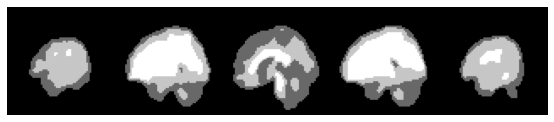

In [215]:
priorseg['segmentation'].plot(nslices=5)

In [226]:
#df['BIDS_ID'][patients].values

In [302]:
#pref = 'c1'


In [762]:
def get_gseg(subID,anat):
    #subID='sub-001'
    fn = '/mmfs1/data/aglinska/fMRI_InData/abide_bids/{subID}/anat/{pref}{subID}{tail}.nii'

    c1 = ants.image_read(fn.format(pref='c1',subID=subID,tail='_T1w'))
    c2 = ants.image_read(fn.format(pref='c2',subID=subID,tail='_T1w'))
    c3 = ants.image_read(fn.format(pref='c3',subID=subID,tail='_T1w'))
    T1 = ants.image_read(fn.format(pref='',subID=subID,tail='_T1w'))
    #T1 = ants.image_read(fn.format(pref='',subID=subID,tail='_brain'))

    brain = T1.copy()

    brain[(c1+c2+c3)<.8]=0

    gseg = brain.new_image_like(np.zeros(brain.numpy().shape))
    gseg[c1>.5]=1 #gray matter
    gseg[c2>.5]=2 # white matter
    gseg[c3>.5]=3 # CSF

    brain_tiny = ants.resample_image(image=brain,resample_params=(64,64,64),use_voxels=True,interp_type=1)
    gseg_tiny = ants.resample_image(image=gseg,resample_params=(64,64,64),use_voxels=True,interp_type=1)

    brain_tiny.set_origin(anat.origin)
    gseg_tiny.set_origin(anat.origin)
    
    #brain_tiny.plot(nslices=5,overlay=anat,overlay_alpha=.3)
    #tx = ants.registration(fixed=anat,moving=brain_tiny,type_of_transform='Rigid')
    #brain_tiny = ants.apply_transforms(fixed=anat,moving=brain_tiny,transformlist=tx['fwdtransforms'],interpolator='nearestNeighbor')
    #gseg_tiny = ants.apply_transforms(fixed=anat,moving=gseg_tiny,transformlist=tx['fwdtransforms'],interpolator='nearestNeighbor')
    
    return brain_tiny,gseg_tiny

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [763]:
map_ = get_umap_corners(s_embedding)

392
sub-828


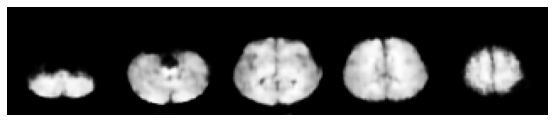

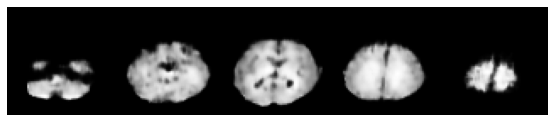

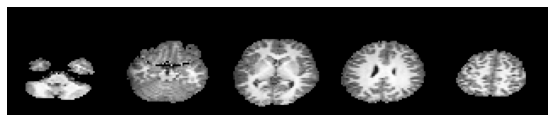

In [1165]:
idx = map_['lr'][6]
print(idx)

subID = df['BIDS_ID'].values[patients][idx]
print(subID)
#nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])

b_vec = space_bg[idx,:]
s_vec = space_sl[idx,:]

vec_asd = np.hstack((b_vec,s_vec))
vec_td = np.hstack((b_vec,np.zeros(16)))

im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]

brain_tiny,gseg_tiny = get_gseg(subID,anat)
anat = brain_tiny.new_image_like(abide_asd[idx,:,:,:])

nii_td = brain_tiny.new_image_like(im_td)
nii_asd = brain_tiny.new_image_like(im_asd)

#nii_asd = ants.registration(fixed=brain_tiny,moving=nii_asd,type_of_transform='Rigid')['warpedmovout']
#nii_td = ants.registration(fixed=brain_tiny,moving=nii_td,type_of_transform='Rigid')['warpedmovout']

nii_td.plot(nslices=5,axis=2)
nii_asd.plot(nslices=5,axis=2)
brain_tiny.plot(nslices=5,axis=2)

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



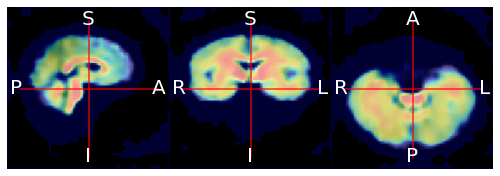

In [1157]:
nii_asd.plot_ortho(overlay=nii_td,overlay_alpha=.4,flat=True)

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



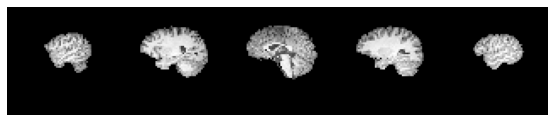

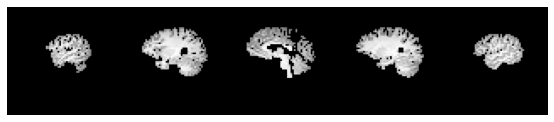

In [1158]:
brain_tiny.plot(nslices=5)
anat.plot(nslices=5)

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



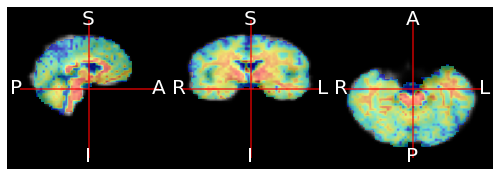

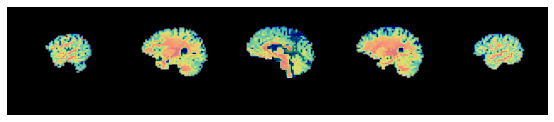

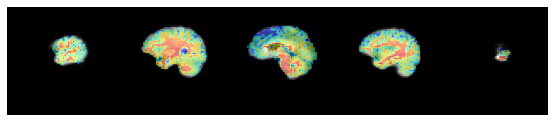

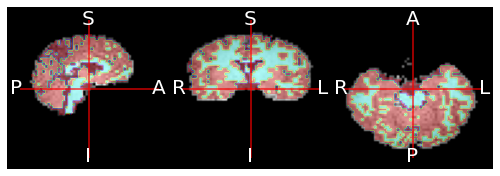

In [1159]:
#brain_tiny.plot_ortho(overlay=gseg_tiny,flat=True,overlay_alpha=.3)
nii_td.plot_ortho(overlay=brain_tiny,flat=True,overlay_alpha=.5)
anat.plot(overlay=brain_tiny,nslices=5,overlay_alpha=.5)
nii_td.plot(overlay=brain_tiny,nslices=5,overlay_alpha=.5)
brain_tiny.plot_ortho(overlay=gseg_tiny,flat=True,overlay_alpha=.3,overlay_cmap='hsv')
#nii_asd.plot_ortho(overlay=gseg_tiny,flat=True,overlay_alpha=.3,cmap='gray',overlay_cmap='hsv')

In [1160]:
c1 = gseg_tiny.copy()
c2 = gseg_tiny.copy()
c3 = gseg_tiny.copy()
c1[c1!=1]=0;c1[c1==1]=1.0
c2[c2!=2]=0;c2[c2==2]=1.0
c3[c3!=3]=0;c3[c3==3]=1.0

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



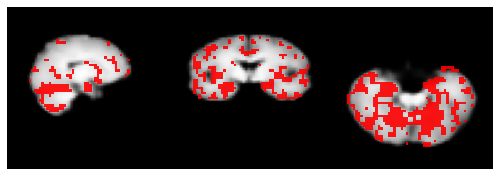

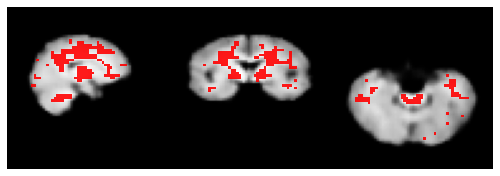

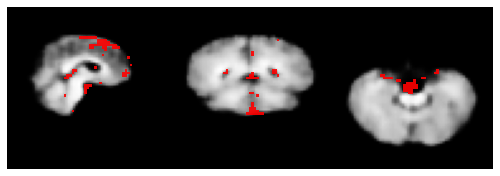

In [1161]:
nii_td.plot_ortho(c1,flat=True,xyz_lines=False,orient_labels=False,xyz=(25,32,32),overlay_cmap='hsv')
nii_td.plot_ortho(c2,flat=True,xyz_lines=False,orient_labels=False,xyz=(25,32,32),overlay_cmap='hsv')
nii_td.plot_ortho(c3,flat=True,xyz_lines=False,orient_labels=False,xyz=(30,22,32),overlay_cmap='hsv')

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



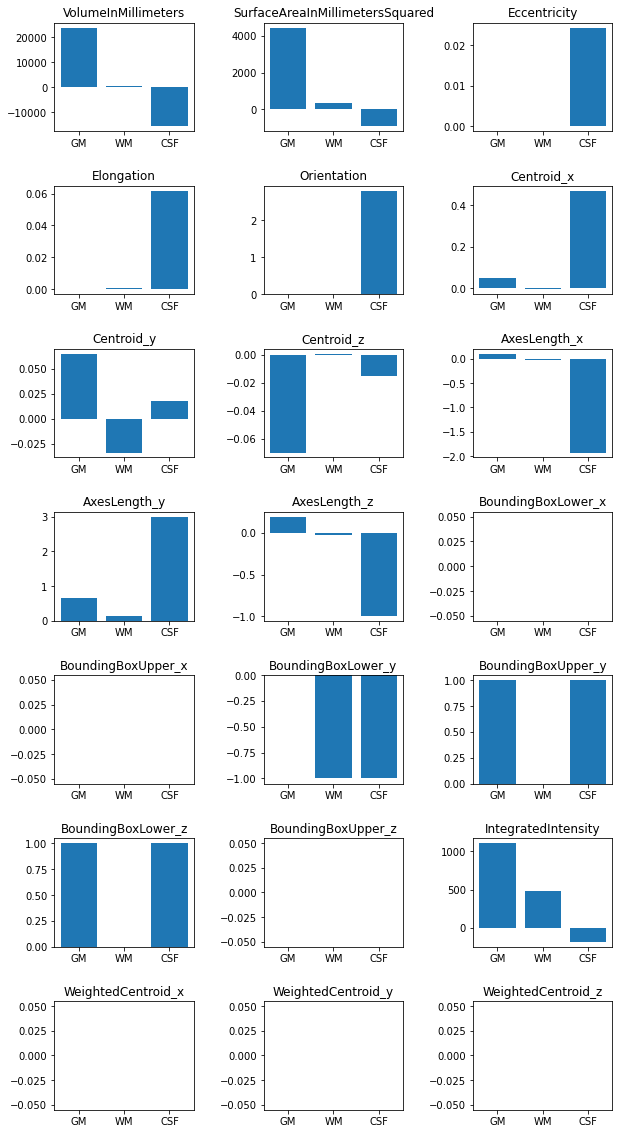

In [1162]:
priorweight = .25;mrf = .1;nit = 25

pseg_td = ants.prior_based_segmentation(
    image=nii_td,
    priors=[c1,c2,c3],
    mask=nii_td.get_mask(),
    priorweight=priorweight,
    mrf=mrf,
    iterations=nit)

geom_td = ants.label_geometry_measures(pseg_td['segmentation'],nii_td)

pseg_asd = ants.prior_based_segmentation(
    image=nii_asd,
    priors=[c1,c2,c3],
    mask=nii_asd.get_mask(),
    priorweight=priorweight,
    mrf=mrf,
    iterations=nit)

geom_asd = ants.label_geometry_measures(pseg_asd['segmentation'],nii_asd)
#plt.bar([0,1,2],(geom2-geom1)['VolumeInMillimeters'].values)

keys = list((geom_asd-geom_td).keys())[1::]
plt.figure(figsize=(10,20))
csf = True
for i in range(21):
    plt.subplot(7,3,i+1)
    
    if csf:
        xs = [0,1,2]
        vals = (geom_asd-geom_td)[keys[i]].values[0:3]
        plt.bar(xs,vals)
        plt.title(keys[i])
        plt.xticks(xs,labels=['GM','WM','CSF'])
    else:    
        xs = [0,1]
        vals = (geom_asd-geom_td)[keys[i]].values[0:2]
        plt.bar(xs,vals)
        plt.title(keys[i])
        plt.xticks(xs,labels=['GM','WM'])

plt.subplots_adjust(hspace=.5,wspace=.5)

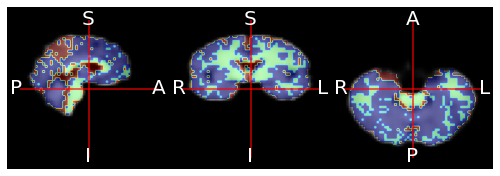

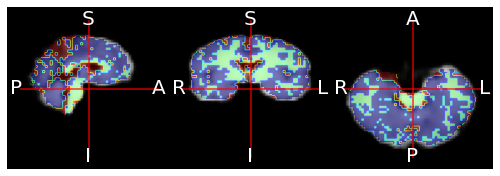

In [1163]:
nii_td.plot_ortho(overlay=pseg_td['segmentation'],overlay_alpha=.5,flat=True)
nii_asd.plot_ortho(overlay=pseg_td['segmentation'],overlay_alpha=.5,flat=True)

In [527]:
c1 = ants.image_read('/mmfs1/data/aglinska/c1template.nii')
c2 = ants.image_read('/mmfs1/data/aglinska/c2template.nii')
c3 = ants.image_read('/mmfs1/data/aglinska/c3template.nii')

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [572]:
%%time
def func_get_vals(corner,i):
    #corner = 'tl'
    #i = 0
    map_ = get_umap_corners(s_embedding)
    idx = map_[corner][i]
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])
    anat = im.new_image_like(abide_asd[idx,:,:,:])
    norm_td,norm_asd,norm = norm_brains(anat, template, nii_td, nii_asd,return_tx=True)

    priors = [c1,c2,c3]
    priorweight = .25;mrf = .1;nit = 50
    tseg1 = ants.prior_based_segmentation(image=norm_td,priors=priors,mask=norm_td.get_mask(),priorweight=priorweight,mrf=mrf,iterations=nit)
    tseg2 = ants.prior_based_segmentation(image=norm_asd,priors=priors,mask=norm_asd.get_mask(),priorweight=priorweight,mrf=mrf,iterations=nit)

    geom1 = ants.label_geometry_measures(tseg1['segmentation'],norm_td)
    geom2 = ants.label_geometry_measures(tseg2['segmentation'],norm_asd)
    vals = np.array((geom2-geom1)['VolumeInMillimeters'])
    return vals

CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 116 µs


In [577]:
vec_tl = np.array([func_get_vals('tl',i) for i in tqdm(range(5))])
vec_tr = np.array([func_get_vals('tr',i) for i in tqdm(range(5))])
vec_ll = np.array([func_get_vals('ll',i) for i in tqdm(range(5))])
vec_lr = np.array([func_get_vals('lr',i) for i in tqdm(range(5))])

100%|██████████| 5/5 [01:23<00:00, 16.78s/it]


<ErrorbarContainer object of 3 artists>

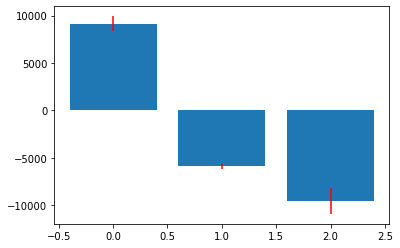

In [591]:
vec = vec_tr
xs = np.arange(3)
m = vec.mean(axis=0)
se = vec.std(axis=0)

plt.bar(xs,m)
plt.errorbar(xs,m,se,fmt='r ')

([<matplotlib.axis.XTick at 0x154c4011dfd0>,
 [Text(0, 0, 'll'), Text(1, 0, 'lr'), Text(2, 0, 'tr'), Text(3, 0, 'tl')])

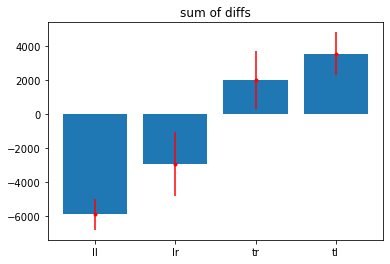

In [128]:
xs = np.arange(4)
arrs = np.array([vec1,vec2,vec3,vec4])

m  = arrs.sum(axis=4).sum(axis=3).sum(axis=2).sum(axis=1)
se = arrs.sum(axis=4).sum(axis=3).sum(axis=2).std(axis=1)
# m = [np.array(vec).sum() for vec in [vec1,vec2,vec3,vec4]]
# se = [np.array(vec).std() for vec in [vec1,vec2,vec3,vec4]]

plt.bar(xs,m)
plt.errorbar(xs,m,se,fmt='r.')
plt.title('sum of diffs')
plt.xticks(xs,['ll','lr','tr','tl'])

In [926]:
nrep = 25
ll_list = [func_get_td_to_asd_warp('ll',i).numpy() for i in tqdm(range(nrep))]
lr_list = [func_get_td_to_asd_warp('lr',i).numpy() for i in tqdm(range(nrep))]
tr_list = [func_get_td_to_asd_warp('tr',i).numpy() for i in tqdm(range(nrep))]
tl_list = [func_get_td_to_asd_warp('tl',i).numpy() for i in tqdm(range(nrep))]

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 25/25 [00:53<00:00,  2.15s/it]


In [927]:
map_ = get_umap_corners(s_embedding)
idx = map_['ll'][0]
nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])
anat = im.new_image_like(abide_asd[idx,:,:,:])
norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
warp = ants.registration(fixed=norm_asd,moving=norm_td,type_of_transform='SyNOnly')
warp_nii = ants.image_read(warp['fwdtransforms'][0])

In [928]:
def func_normalize(ll_mat):
    return (ll_mat-ll_mat.flatten().min()) / (ll_mat.flatten().max()-ll_mat.flatten().min())

In [929]:
ll_mat = np.array(ll_list).mean(axis=0)
lr_mat = np.array(lr_list).mean(axis=0)
tr_mat = np.array(tr_list).mean(axis=0)
tl_mat = np.array(tl_list).mean(axis=0)


ll = warp_nii.new_image_like(ll_mat)
lr = warp_nii.new_image_like(lr_mat)
tr = warp_nii.new_image_like(tr_mat)
tl = warp_nii.new_image_like(tl_mat)

In [930]:
from datetime import datetime

In [931]:
# c = np.sqrt(((np.array([u,v,w])-np.ones(np.array([u,v,w]).shape))**2).sum(axis=0))
# c[c<-2] = c.min()
# c[c>2] = c.max()

In [932]:
def plot_warp_3d(nii_tx,ax=None):
    # 64,64,64,3
#     %matplotlib inline
#     nii_tx = warp_nii

    targ_size = np.repeat(8,3)
    tx_mat = np.array([template.new_image_like(nii_tx.numpy()[:,:,:,i]).resample_image(targ_size,use_voxels=True).numpy() for i in range(3)])
    tx_mat = np.array([scipy.stats.zscore(tx_mat[i,:,:,:].flatten()).reshape(targ_size) for i in range(3)])
    
    if not ax:
        fig = plt.figure(figsize=(10,10))
        ax = fig.gca(projection='3d')

    x, y, z = np.meshgrid(np.arange(tx_mat.shape[1]),
                          np.arange(tx_mat.shape[1]),
                          np.arange(tx_mat.shape[1]))

    u = tx_mat[0,:,:,:];u = np.rot90(u,k=1, axes=(0, 1));
    v = tx_mat[1,:,:,:];v = np.rot90(v,k=1, axes=(0, 1));
    w = tx_mat[2,:,:,:];w = np.rot90(w,k=1, axes=(0, 1));
    
    c = np.sqrt(((np.array([u,v,w])-np.ones(np.array([u,v,w]).shape))**2).sum(axis=0))
    c[c<-5] = c.min();c[c>5] = c.max()
    c = (c.ravel() - c.min()) / c.ptp()
    c = np.concatenate((c, np.repeat(c, 2)))
    c = plt.cm.RdYlBu(c)
    #c = plt.cm.hot(c)
    ax.quiver(x, y, z, u, v, w,length=.5,arrow_length_ratio=0.3,pivot='tail',normalize=False,alpha=.5,colors=c,clim=(-2,0))
    

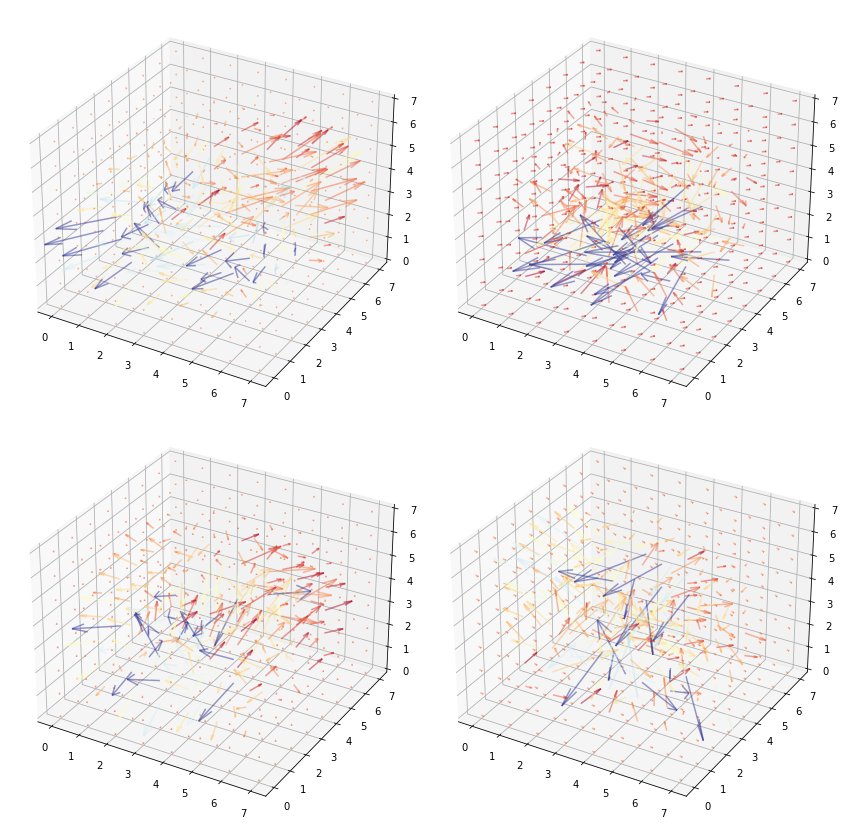

In [933]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1, projection='3d')
plot_warp_3d(tl,ax=ax)
#ax.set_title('TL')

ax = fig.add_subplot(2, 2, 2, projection='3d')
plot_warp_3d(tr,ax=ax)
#ax.set_title('TR')

ax = fig.add_subplot(2, 2, 3, projection='3d')
plot_warp_3d(ll,ax=ax)
#ax.set_title('LL')

ax = fig.add_subplot(2, 2, 4, projection='3d')
plot_warp_3d(lr,ax=ax)
#ax.set_title('LR')
plt.subplots_adjust(hspace=.01,wspace=.01)
#plt.savefig('/mmfs1/data/aglinska/figures/' + 'group_vectorfields' + '.png',dpi=300)

CPU times: user 10.9 s, sys: 234 ms, total: 11.1 s
Wall time: 10.9 s


{(5, 25, 25): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1549a4f7a760>,
 (5, 25, 29): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1549cc066dc0>,
 (5, 26, 24): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1549cc066e20>,
 (5, 26, 29): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1549cc066760>,
 (5, 27, 23): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1549cc044850>,
 (5, 27, 30): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1549cc044af0>,
 (5, 28, 23): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1549cc0445b0>,
 (5, 28, 30): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1549cc044040>,
 (5, 29, 23): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1549cc044640>,
 (5, 29, 29): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154a2fb43940>,
 (5, 34, 24): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154a2fb436a0>,
 (5, 34, 29): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x154a2fb43310>,
 (5, 35, 24): <mpl_toolkits.mplot3d.art3d.Poly3DColl

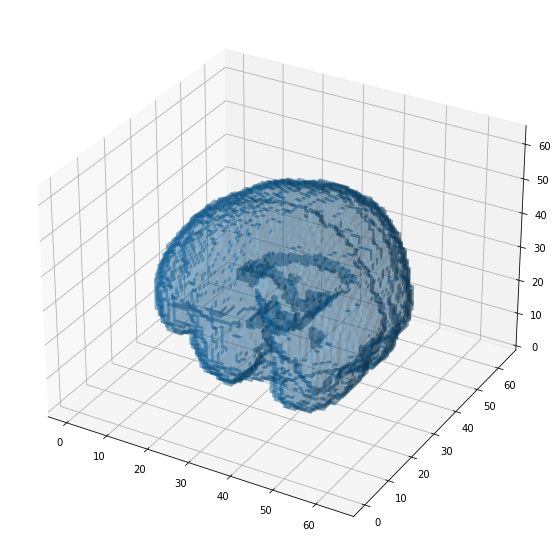

In [934]:
%%time
#arr = anat.numpy();
arr = template.numpy()
i=1;arr = arr[0::i,0::i,0::i];
#arr = np.rot90(arr,axes=(1,2))
arr = np.rot90(arr,k=1, axes=(0, 1));
#arr = np.rot90(arr,k=2, axes=(1,0))
fig = plt.figure(figsize=(10,10));
ax = fig.gca(projection='3d');
ax.voxels(arr,alpha=.3);
#plt.savefig('/mmfs1/data/aglinska/figures/' + 'brain_orient' + '.png',dpi=300)

In [74]:
#[plot_ortho_deformations(template.numpy(),tr.numpy()[:,:,:,i],cmap='bwr',clim=(-2,2)) for i in range(3)];
#plt.savefig('/mmfs1/data/aglinska/figures/temp.png',dpi=300)

In [75]:
def plot_ortho_deformations(bg_arr,ol_arr,cmap='bwr',clim=(-2,2)):
    
    f, axs = plt.subplots(3,3,figsize=(15,15))
    for row in range(3):
        bg_ax = bg_arr[:,:,40]
        bg_cor = bg_arr[:,40,:]
        bg_sag = bg_arr[40,:,:]

        bg_ax = np.rot90(bg_ax)
        bg_cor = np.rot90(bg_cor)
        bg_sag = np.rot90(bg_sag)

        ol_ax = ol_arr[:,:,40,row]
        ol_cor = ol_arr[:,40,:,row]
        ol_sag = ol_arr[40,:,:,row]

        ol_ax = np.rot90(ol_ax)
        ol_cor = np.rot90(ol_cor)
        ol_sag = np.rot90(ol_sag)

        bg = [bg_ax,bg_cor,bg_sag]
        ol = [ol_ax,ol_cor,ol_sag]
        
        c = 0
        for i in range(3): 
            c = c+1
            ax = axs[row][i];
            ax.imshow(bg[i],cmap='gray')
            ims = ax.imshow(ol[i],cmap=cmap,alpha=.3,vmin=clim[0],vmax=clim[1])
            ax.set_xticks([]);ax.set_yticks([]);
            plt.colorbar(ims,ax=ax,shrink=.7,ticks=np.linspace(clim[0],clim[1],5))

        plt.subplots_adjust(hspace=.004,wspace=.005)

In [76]:
# plot_ortho_deformations(template.numpy(),ll.numpy()[:,:,:,:],cmap='bwr',clim=(-2,2));
# plt.savefig('/mmfs1/data/aglinska/figures/plot_ll.png',dpi=300)

# plot_ortho_deformations(template.numpy(),tl.numpy()[:,:,:,:],cmap='bwr',clim=(-2,2));
# plt.savefig('/mmfs1/data/aglinska/figures/plot_tl.png',dpi=300)

# plot_ortho_deformations(template.numpy(),lr.numpy()[:,:,:,:],cmap='bwr',clim=(-2,2));
# plt.savefig('/mmfs1/data/aglinska/figures/plot_lr.png',dpi=300)

# plot_ortho_deformations(template.numpy(),tr.numpy()[:,:,:,:],cmap='bwr',clim=(-2,2));
# plt.savefig('/mmfs1/data/aglinska/figures/plot_tr.png',dpi=300)

In [77]:
subvec = sfari_subs_del+sfari_subs_dupl
data_sfari = SFARI_data[subvec,:,:,:]

In [78]:
sfari_space_sl = s_encoder.predict(data_sfari)[2]
sfari_space_bg = z_encoder.predict(data_sfari)[2]
sfari_embedding = reducer.fit_transform(sfari_space_sl)

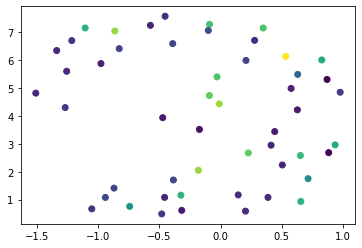

In [79]:
plt.scatter(sfari_embedding[:,0],sfari_embedding[:,1],c=dfs['age_months'].values[subvec])

In [80]:
def func_get_td_to_asd_warp_sfari(corner,i):
    map_ = get_umap_corners(sfari_embedding)
    idx = map_[corner][i]
    nii_td,nii_asd = get_brain_pair(sfari_space_bg[idx,:], sfari_space_sl[idx,:])
    anat = im.new_image_like(data_sfari[idx,:,:,:])
    norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
    warp = ants.registration(fixed=norm_asd,moving=norm_td,type_of_transform='SyNOnly')
    warp_nii = ants.image_read(warp['fwdtransforms'][0])
    return warp_nii

100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Text(0.5, 0.92, 'TR')

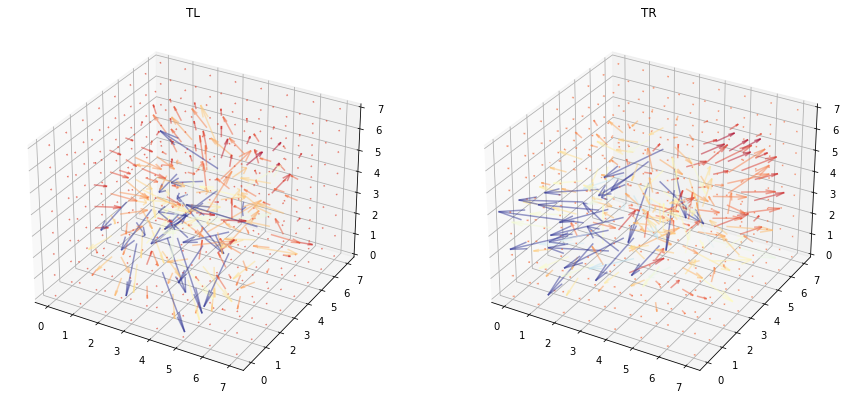

In [81]:
nrep = 5
tl_list = [func_get_td_to_asd_warp_sfari('ll',i).numpy() for i in tqdm(range(nrep))]
lr_list = [func_get_td_to_asd_warp_sfari('tr',i).numpy() for i in tqdm(range(nrep))]


tl_mat = np.array(tl_list).mean(axis=0)
lr_mat = np.array(lr_list).mean(axis=0) 

tl = warp_nii.new_image_like(tl_mat)
lr = warp_nii.new_image_like(lr_mat)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1, projection='3d')
plot_warp_3d(tl,ax=ax)
ax.set_title('TL')

ax = fig.add_subplot(2, 2, 2, projection='3d')
plot_warp_3d(tr,ax=ax)
ax.set_title('TR')

In [82]:
i = 300
b_vec = space_bg[i,:]
s_vec= space_sl[i,:]
vec_asd = np.hstack((b_vec,s_vec))
vec_td = np.hstack((b_vec,np.zeros(16)))
im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]

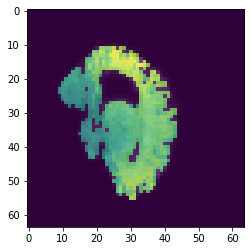

In [83]:
mat1 = abide_asd[i,40,:,:]
mat2 = im_asd[40,:,:]

plt.imshow(mat1)
plt.imshow(mat2,cmap='gray',alpha=.3)

In [84]:
anat = im.new_image_like(ABIDE_data[i,:,:,:])

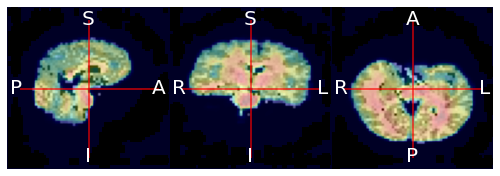

In [85]:
idx = inverse_tx_umap([11,13], s_embedding)
#idx = inverse_tx_umap([5.5,12], s_embedding)
#idx = inverse_tx_umap([8,15], s_embedding)
#idx = inverse_tx_umap([8,10], s_embedding)

idx = idx[20]
s = idx
nii_td,nii_asd = get_brain_pair(space_bg[s,:],space_sl[s,:])
anat = im.new_image_like(abide_asd[idx,:,:,:])
anat.plot_ortho(flat=True,overlay=nii_asd,overlay_alpha=.3)
norm_td,norm_asd = norm_brains(anat,template,nii_td, nii_asd)

In [86]:
idx = inverse_tx_umap([11,13], s_embedding)
#idx = inverse_tx_umap([5.5,12], s_embedding)
#idx = inverse_tx_umap([8,15], s_embedding)
#idx = inverse_tx_umap([8,10], s_embedding)

idx = idx[0]
s = idx
nii_td,nii_asd = get_brain_pair(space_bg[s,:],space_sl[s,:])
anat = im.new_image_like(abide_asd[idx,:,:,:])
#anat.plot_ortho(flat=True,overlay=nii_asd,overlay_alpha=.3)
norm_td,norm_asd1 = norm_brains(anat,template,nii_td, nii_asd)

/data/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [87]:
# grid = ants.create_warped_grid(
#     image=mi,
#     grid_step=10,
#     grid_width=2,
#     grid_directions=(False, True),
#     fixed_reference_image=fi,
#     transform=tx['fwdtransforms'][0],
#     foreground=1,
#     background=0,
# )

# grid.plot_ortho(flat=True)

# grid.plot(slices=(15,25,35,45),axis=0)
# grid.plot(slices=(25,30,35,45),axis=1)
# grid.plot(slices=(30,35,45,50),axis=2)

In [88]:
# im.new_image_like(nii_tx.numpy()[:,:,:,0]).plot(nslices=5)
# im.new_image_like(nii_tx.numpy()[:,:,:,1]).plot(nslices=5)
# im.new_image_like(nii_tx.numpy()[:,:,:,2]).plot(nslices=5)

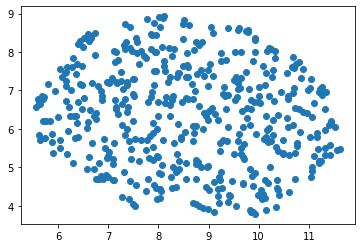

In [89]:
plt.scatter(s_embedding[:,0],s_embedding[:,1])

In [90]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

In [91]:
def plot_tx_space(idx):
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:],space_sl[idx,:])

    tx = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='SyN')
    nii_tx = ants.image_read(tx['fwdtransforms'][0])
    
    targ_size = (8,8,8)
    tx_mat = np.array([im.new_image_like(nii_tx.numpy()[:,:,:,i]).resample_image(targ_size,use_voxels=True).numpy() for i in range(3)])

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')

    x, y, z = np.meshgrid(np.arange(tx_mat.shape[1]),
                          np.arange(tx_mat.shape[1]),
                          np.arange(tx_mat.shape[1]))

    u = tx_mat[0,:,:,:]
    v = tx_mat[1,:,:,:]
    w = tx_mat[2,:,:,:]

    ax.quiver(x, y, z, u, v, w,length=.5,arrow_length_ratio=0.3,pivot='tail',normalize=False)
    ax.set_title(f'S{idx},X:{s_embedding[idx,0]:.2f} Y{s_embedding[idx,1]:.2f}',fontsize=20)
    plt.show()

In [92]:
# i = 0
# idx0 = inverse_tx_umap([-1.5,9],s_embedding)
# idx1 = inverse_tx_umap([1,13],s_embedding)
# idx2 = inverse_tx_umap([4,11],s_embedding)
# idx3 = inverse_tx_umap([1,8],s_embedding)

# plot_tx_space(idx0[i])
# plot_tx_space(idx1[i])
# plot_tx_space(idx2[i])
# plot_tx_space(idx3[i])

In [93]:
flow.shape

(64, 64, 2)

In [95]:
# U  = flow[0:-1:2,0:-1:2,0]
# V  = flow[0:-1:2,0:-1:2,1]
# plot_vecfield_2d(U,V)

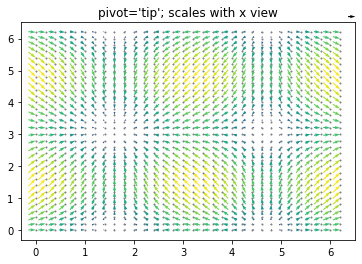

In [96]:
X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)

fig3, ax3 = plt.subplots()
ax3.set_title("pivot='tip'; scales with x view")

M = np.hypot(U, V)

Q = ax3.quiver(X, Y, U, V, M, units='x', pivot='tip', width=0.022,
               scale=1 / 0.15)

qk = ax3.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
ax3.scatter(X, Y, color='0.5', s=1)

plt.show()

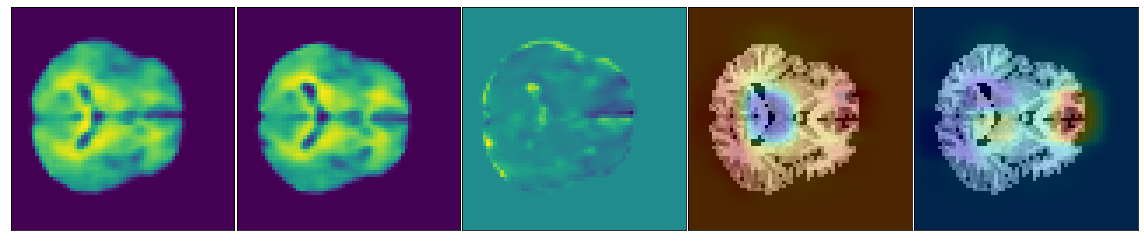

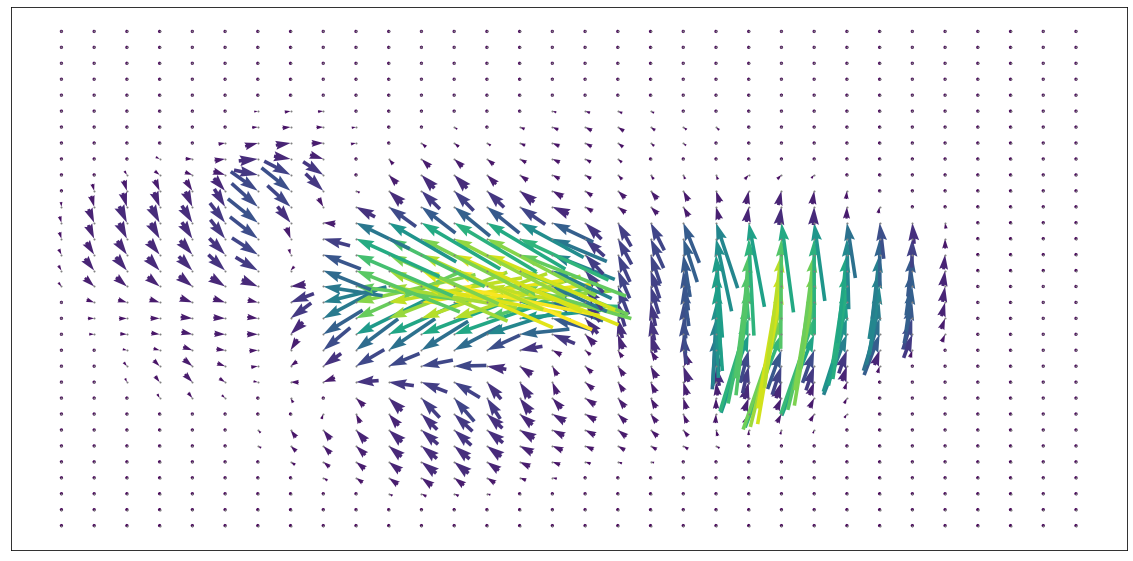

In [110]:
#for i in range(5):

map_ = get_umap_corners(s_embedding)
idx = map_['tr'][0]
s = idx
nii_td,nii_asd = get_brain_pair(space_bg[s,:],space_sl[s,:])
anat = im.new_image_like(abide_asd[idx,:,:,:])


# map_ = get_umap_corners(sfari_embedding)
# idx = map_['tl'][5]
# nii_td,nii_asd = get_brain_pair(sfari_space_bg[idx,:], sfari_space_sl[idx,:])
# anat = im.new_image_like(data_sfari[idx,:,:,:])


#norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
#nii_td,nii_asd = norm_td,norm_asd

bg = anat.numpy()
ax = 0
if ax==0:
    j = np.argmax([nii_td.numpy()[:,:,i].sum() for i in range(64)])
    P = nii_td.numpy()[:,:,j]
    N = nii_asd.numpy()[:,:,j]
    anat_slice = bg[:,:,j]
elif ax==1:
    j = np.argmax([nii_td.numpy()[:,i,:].sum() for i in range(64)])
    P = nii_td.numpy()[:,j,:]
    N = nii_asd.numpy()[:,j,:]
    anat_slice = bg[:,j,:]
elif ax==2:
    j = np.argmax([nii_td.numpy()[i,:,:].sum() for i in range(64)])
    P = nii_td.numpy()[j,:,:]
    N = nii_asd.numpy()[j,:,:]
    anat_slice = bg[j,:,:]

#flow = cv2.calcOpticalFlowFarneback(N,P, None, 0.5, 3, 15, 3, 5, 1.2, 0)
flow = cv2.calcOpticalFlowFarneback(P,N, None, 0.5, 3, 15, 3, 5, 1.2, 0)
flow = np.reshape(scipy.stats.zscore(flow.flatten()),flow.shape)
#flow[abs(flow)<1.96] = 0

plt.figure(figsize=(16,10))
plt.subplot(1,5,1)
plt.imshow(P);plt.xticks([]);plt.yticks([])
plt.subplot(1,5,2)
plt.imshow(N);plt.xticks([]);plt.yticks([])

plt.subplot(1,5,3)
plt.imshow(P-N);plt.xticks([]);plt.yticks([])

plt.subplot(1,5,4)
plt.imshow(anat_slice,cmap='gray')
plt.imshow(flow[:,:,0],cmap='jet',alpha=.3);plt.xticks([]);plt.yticks([])

plt.subplot(1,5,5)
plt.imshow(anat_slice,cmap='gray');plt.xticks([]);plt.yticks([])
plt.imshow(flow[:,:,1],cmap='jet',alpha=.3);plt.xticks([]);plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=.01,wspace=.01,top=.5,)

f, ax = plt.subplots(1,1,figsize=(20,10))
U  = flow[0::2,0::2,0]
V  = flow[0::2,0::2,1]
plot_2dvecfield(U,V,ax=ax)